In [1]:
# tld library is a Python package that provides functionality for working 
# with top-level domains (TLDs) and extracting domain names from URLs.
!pip install tld


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

In [3]:
data = pd.read_csv('malicious_phish.csv', nrows = 1000)

In [4]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
data.shape

(1000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     1000 non-null   object
 1   type    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [7]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [8]:
count = data.type.value_counts()
count

benign        734
defacement    181
phishing       54
malware        31
Name: type, dtype: int64

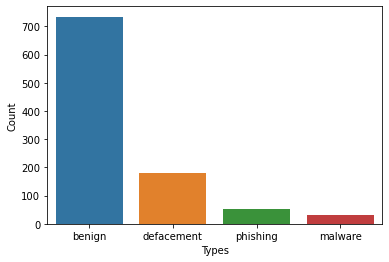

In [9]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [10]:
# omit the (www.) from the URL which is in fact a sub domain in itself.
data['url'] = data['url'].replace('www.', '', regex=True)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [11]:
# Mapping Categoricals in Type
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

# Feature Extraction

In [12]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [13]:
data.head()

,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


In [14]:
# TLD specifies the domain name of the website or resource being accessed.
# Eg: ".com", ".org", ".net", ".edu"

In [15]:
# extracting the primary domain (i.e., the domain name without the TLD or any subdomains)
#  If the URL cannot be processed for any reason, the function returns 'None'
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [16]:
# Create another variable with TLD 
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [17]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [18]:
# Count the number of occurrences of that character in each URL

feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [19]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [20]:
# Extract the hostname from the URL.
# Converted to string
# Search for the hostname in the URL.

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [21]:
# For example, let's say the domain name of a legitimate website is "example.com".
# If someone creates a fake URL like "https://www.example.com.phishing.com", the abnormal_url()
# function will detect this as suspicious because the domain name ("example.com") appears
# in an unexpected location (in the middle of the URL).

In [22]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

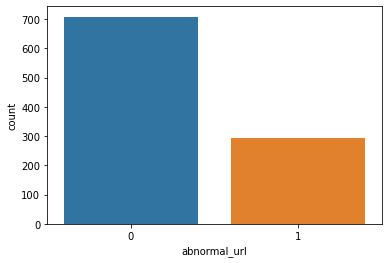

In [23]:
# 1 URL is abnornal
# 0 URL is normal
sns.countplot(x='abnormal_url', data=data);

In [24]:
# Classify between https and http 
# https- secure- 1
# http- unsecure- 0
# scheme- protocol used to access the url (http, https)
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [25]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

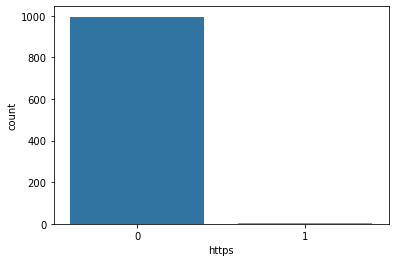

In [26]:
sns.countplot(x='https', data=data);

In [27]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0


In [28]:
# Count the number of digits in a given URL
# looping through each character in the URL and checking if it's a numeric digit using the .isnumeric()

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
# The digit_count() function can help identify potentially suspicious URLs that contain an unusually high
# number of digits, which may be an indication of phishing or spoofing attempts.

In [29]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [30]:
# Used to count the number of letters (i.e., alphabetic characters) in a given URL.
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [31]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [32]:
# Checks if a given URL uses a known URL shortening service such as bit.ly or goo.gl.
#  URL shortening services are used to create shorter versions of URLs that can be more
# easily shared or typed, but they can also be used to disguise the true destination of a link.

#  By identifying URLs that use a known URL shortening service, this function can be used to filter out
# potentially suspicious URLs from a larger dataset. If the function returns a value of 1,
# it means the URL uses a known URL shortening service, while a value of 0 indicates that it does not.

def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [33]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

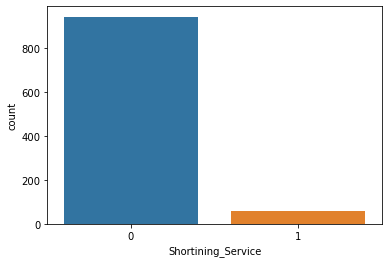

In [34]:
sns.countplot(x='Shortining_Service', data=data);

In [35]:
# The regular expression consists of several parts that match different types of IP addresses:
# IPv4 addresses (with or without a port number)
# IPv4 addresses represented in hexadecimal
# IPv6 addresses (with or without a prefix length)

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
# This is a Python function that takes a URL as input and returns 1
#if the URL contains an IP address (IPv4 or IPv6) and 0 otherwise.

In [36]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [37]:
data['having_ip_address'].value_counts()

0    1000
Name: having_ip_address, dtype: int64

<AxesSubplot:>

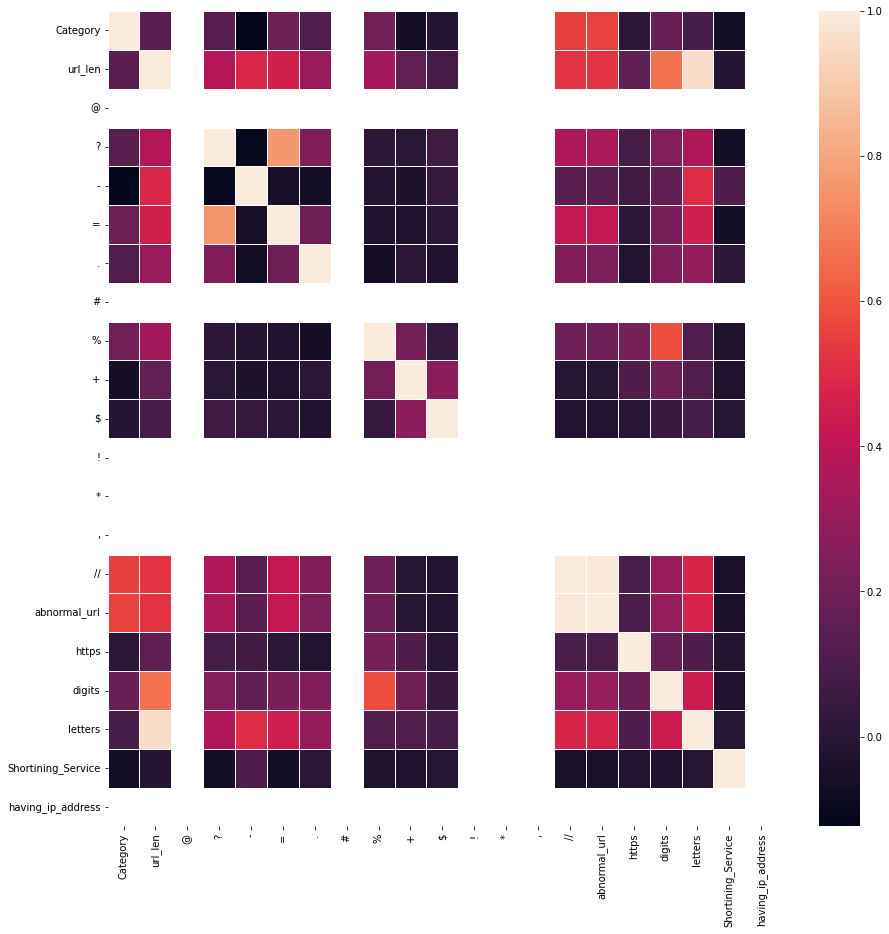

In [38]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [39]:
data

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,youtube.com/watch?v=EcGsM-PNQHQ,benign,0,31,youtube.com,0,1,1,1,1,...,0,0,0,0,0,0,0,26,0,0
996,bloomberg.com/news/2011-08-28/dust-bowl-in-tex...,benign,0,109,bloomberg.com,0,0,14,0,2,...,0,0,0,0,0,0,8,82,0,0
997,http://slavia.sk/home,defacement,1,21,slavia.sk,0,0,0,0,1,...,0,0,0,1,1,0,0,16,0,0
998,innerearbrigade.com/,benign,0,20,innerearbrigade.com,0,0,0,0,1,...,0,0,0,0,0,0,0,18,0,0


In [40]:
# Drop url, domain (lots of unique values)
# Drop type, Category (Variable we want to predict)
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
Y = data['Category']

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=10)

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
#scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
Lr=LogisticRegression() # applying log reg
Lr.fit(X_train,Y_train)
Y_predlr=Lr.predict(X_test)
Y_predlr

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], d

In [45]:
print(Lr.intercept_)
print()
print(Lr.coef_)
print()
print(Lr.n_iter_)
print()
print(list(zip(data.columns[:-1],Lr.coef_.ravel()))) # ravel changes coef array to 1D

[ 3.07712378 -1.44926633 -0.03450373 -1.59335371]

[[ 1.57600839  0.          0.28208841  0.79817735 -0.21529085  0.02123019
   0.          0.47257702  0.34609617  0.          0.          0.
   0.         -0.12623355 -1.9171629   0.02777778 -0.33043709 -0.62724941
   0.13911306  0.        ]
 [-0.59068509  0.          0.53979525  0.14900156  0.31593402 -0.2045596
   0.         -0.68563259  0.2462979   0.          0.          0.
   0.          0.45506869  1.75111586 -0.29999579 -0.70295619  0.7433968
  -0.36792446  0.        ]
 [-0.62828205  0.         -1.21847153 -0.37014375  0.22901021  0.14910136
   0.         -0.49204833 -0.45037649  0.          0.          0.
   0.         -0.27011373 -0.19445476  0.36098569  0.5058764   0.59216201
  -0.04221735  0.        ]
 [-0.35704126  0.          0.39658786 -0.57703515 -0.32965338  0.03422806
   0.          0.70510391 -0.14201757  0.          0.          0.
   0.         -0.05872141  0.3605018  -0.08876769  0.52751688 -0.7083094
   0.27102875  

In [46]:
#print(list(zip(Y_pred,Y_test)))
print(Lr.score(X_train,Y_train))

0.8985714285714286


In [47]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
cfmlr=confusion_matrix(Y_test,Y_predlr)
print("Confusion matrix by Log Reg:")
print(cfmlr)
class_rlr=classification_report(Y_test,Y_predlr)
print("Classfication rep by Log reg:")
print(class_rlr)
acc_slr=accuracy_score(Y_test,Y_predlr)
print("Accuracy score by Log reg:",acc_slr)

Confusion matrix by Log Reg:
[[220   8   2   0]
 [  2  45   0   0]
 [  8   3   1   1]
 [  1   5   1   3]]
Classfication rep by Log reg:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       230
           1       0.74      0.96      0.83        47
           2       0.25      0.08      0.12        13
           3       0.75      0.30      0.43        10

    accuracy                           0.90       300
   macro avg       0.67      0.57      0.58       300
weighted avg       0.88      0.90      0.88       300

Accuracy score by Log reg: 0.8966666666666666


In [48]:
#predicting using the KNeighbors_Classifier
from sklearn.neighbors import KNeighborsClassifier
model_KNN=KNeighborsClassifier(n_neighbors=int(np.sqrt(len(X_train))),
                              metric='euclidean')
#euclidean, manhattan, minkowski
#fit the model on the data and predict the values
model_KNN.fit(X_train,Y_train)

Y_pred=model_KNN.predict(X_test)
print(list(zip(Y_test,Y_pred)))

[(1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (2, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 0), (0, 0), (2, 0), (3, 0), (0, 0), (1, 1), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (1, 1), (0, 0), (2, 0), (0, 0), (0, 0), (0, 0), (0, 0), (3, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (2, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (2, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (3, 3), (2, 0), (3, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (2, 0), (0, 0), (0, 0), (0, 0),

In [49]:
np.sqrt(len(X_train))

26.457513110645905

In [50]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
cfm=confusion_matrix(Y_test,Y_pred)
print("Confusion matrix:")
print(cfm)
class_r=classification_report(Y_test,Y_pred)
print("Classfication report:")
print(class_r)
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy score:",acc)

Confusion matrix:
[[220   9   0   1]
 [  3  44   0   0]
 [  9   4   0   0]
 [  2   5   0   3]]
Classfication report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       230
           1       0.71      0.94      0.81        47
           2       0.00      0.00      0.00        13
           3       0.75      0.30      0.43        10

    accuracy                           0.89       300
   macro avg       0.60      0.55      0.55       300
weighted avg       0.86      0.89      0.87       300

Accuracy score: 0.89


C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# create a dictionary of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

def print_scores(X_train, Y_train, X_test, Y_test):
    for clf_name, clf in classifiers.items():
        # fit the classifier on the training data
        clf.fit(X_train, Y_train)
        # make predictions on the test data
        Y_pred = clf.predict(X_test)
        # print the confusion matrix
        print(f"Confusion matrix for {clf_name}:")
        print(confusion_matrix(Y_test, Y_pred))
        # print the classification report
        print(f"Classification report for {clf_name}:")
        print(classification_report(Y_test, Y_pred))
        # print the accuracy score
        acc = accuracy_score(Y_test, Y_pred)
        print(f"Accuracy score for {clf_name}: {acc}\n")


In [52]:
print_scores(X_train, Y_train, X_test, Y_test)

Confusion matrix for Logistic Regression:
[[220   8   2   0]
 [  2  45   0   0]
 [  8   3   1   1]
 [  1   5   1   3]]
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       230
           1       0.74      0.96      0.83        47
           2       0.25      0.08      0.12        13
           3       0.75      0.30      0.43        10

    accuracy                           0.90       300
   macro avg       0.67      0.57      0.58       300
weighted avg       0.88      0.90      0.88       300

Accuracy score for Logistic Regression: 0.8966666666666666

Confusion matrix for AdaBoost:
[[148   7   1  74]
 [  1  44   2   0]
 [  4   4   0   5]
 [  3   5   0   2]]
Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77       230
           1       0.73      0.94      0.82        47
           2       0.00      0.0

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

# Create a SVM classifier object
svm = SVC()

# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [54]:
from sklearn.svm import SVC
 
svc_model=SVC(kernel='poly',C=1,gamma='scale')
svc_model.fit(X_train,Y_train)
Y_pred=svc_model.predict(X_test)
print(list(Y_pred))

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [55]:
svc_model.score(X_train,Y_train)

#score-->
#Y_pred=svc_model.predict(X_train)
#accuracy_score(Y_train,Y_pred)

0.9171428571428571

In [56]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
cfmlr=confusion_matrix(Y_test,Y_pred)
print("Confusion matrix by SVM:")
print(cfmlr)
class_rlr=classification_report(Y_test,Y_pred)
print("Classfication rep by SVM:")
print(class_rlr)
acc_slr=accuracy_score(Y_test,Y_pred)
print("Accuracy score by SVM:",acc_slr)

Confusion matrix by SVM:
[[226   4   0   0]
 [  4  43   0   0]
 [  8   4   1   0]
 [  2   4   0   4]]
Classfication rep by SVM:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       230
           1       0.78      0.91      0.84        47
           2       1.00      0.08      0.14        13
           3       1.00      0.40      0.57        10

    accuracy                           0.91       300
   macro avg       0.93      0.59      0.63       300
weighted avg       0.92      0.91      0.89       300

Accuracy score by SVM: 0.9133333333333333


In [57]:
# Logistic regression as well as SVM having the highest accuracy score of 0.896, 0.91 respectively.
# But SVM has low recall and f1-score as compared to Logistic regression.
# So, we go ahead with Logistic regression for Tuning.

In [58]:
import pickle
pickle_out = open("model.pkl", "wb")
pickle.dump(data, pickle_out)
pickle_out.close()